# Work on the OCSEAN DATA for lingpy modelling

This is incomplete, but contains some very important functionality to find issues with the data with a **check** function to search all languages for symbols or word segments.

At present, it assumes you will rerun "process_linguistic_excel_data.ipynb" if you make modifications to the raw data. This should be streamlined.

In [1]:
import pandas as pd
from lingpy import * # We're just importing everything from lingpy for simplicity
from lingpy.sequence.sound_classes import ipa2tokens
import re
import os
import math

## Metadata

We created a list of "good" languages in process_linguistic_excel_data.ipynb, which we can treat as the main reference to link languages to files.

In [2]:
metadata=pd.read_excel("OCSEAN_initial_englishsheet.xlsx")  
metadata.index=metadata['Language_AsInFile']
metadata.head()

,Unnamed: 0,Language_BasedOnMasterSheet,ISO code (from Original_FileName),COUNTRY,LocalWordsPresent,QC_done,AddedToTheUnitedLanguagesMasterFile,Comment,Separator,Mismatches_Eng,Mismatches_IndoOrTaga,Original_FileName,QC_FileName,Google Map Coordinate,latitude,longitude,Used,Has_IPA,Has_English,Language_AsInFile
Language_AsInFile,,,,,,,,,,,,,,,,,,,,
Abui_Bunggeta,0,Abui Bunggeta,ABZ,Indonesia,604,Yes,Yes,Some English and or Indonesian words in this l...,", and ; and ~ (?). Only used , and ;",41,87,OCSEAN-ABZ_20240605-BUNGGETA_WORDLIST.xlsx,OCSEAN-ABZ_20240605-BUNGGETA_WORDLIST_PostQC.xlsx,NaN,NaN,NaN,True,True,True,Abui_Bunggeta
Abui_Kilakawada,1,Abui Kilakawada,ABZ,Indonesia,604,Yes,Yes,English and English Elicitation notes complete...,", and ; and ~ (?). Only used , and ;",41,87,OCSEAN-ABZ_20240606-KILAKAWADA_WORDLIST.xlsx,OCSEAN-ABZ_20240606-KILAKAWADA_WORDLIST_PostQC...,NaN,NaN,NaN,True,False,True,Abui_Kilakawada
Abui_Mobyetang,2,Abui Mobyetang,ABZ,Indonesia,602,Yes,Yes,English Elicitation = English actually. Some E...,", and ; and ~ (?). Only used , and ;",41,87,OCSEAN-ABZ_20240610-MOBYETANG_WORDLIST.xlsx,OCSEAN-ABZ_20240610-MOBYETANG_WORDLIST_PostQC....,NaN,NaN,NaN,True,False,True,Abui_Mobyetang
Abui_Pelman,3,Abui Pelman,ABZ,Indonesia,602,Yes,Yes,English Elicitation = English actually. Some E...,", and ; and ~ (?). Only used , and ;",41,87,OCSEAN-ABZ_20240610-PELMAN_WORDLIST.xlsx,OCSEAN-ABZ_20240610-PELMAN_WORDLIST_PostQC.xlsx,NaN,NaN,NaN,True,False,True,Abui_Pelman
Agusan_Manobo,10,Agusan Manobo,MSM,the Phillipines,1225,Yes,Yes,Tagalog and English present and both match the...,",",FALSE,FALSE,OCSEAN-MSM_20240517-WORDLIST_1to1228.xlsx,OCSEAN-MSM_20240517-WORDLIST_1to1228_PostQC.xlsx,"9°15'55.8""N 125°33'33.5""E",9.2655,125.559306,True,False,True,Agusan_Manobo


### Using the metadata:

We cal lookup the file associated with 'Balinese' with the following code. Its in the "CleanedFiles" folder.

In [3]:
metadata.loc['Balinese','QC_FileName']

'OCSEAN-BAN_20220714-WORDLIST_PostQC.xlsx'

## Reading our data

We can read in our data very simply, as its been processed into a simple dataset of 'concept','form' and 'doculect'. (There is an ID column too, just a number to identify each row).

In [4]:
od = pd.read_table('OCSEAN_initial_joineddata.tsv')
od=od[['ID','concept','form','doculect']]

Its very important to be able to search for "bad characters" that cannot be converted to IPA and might indicate problems for manual examination. These functions do that, and we have examples of their use below. Don't worry too much about how they work just yet.

First we define a list of "bad symbols" for later use, then define the functions.

In [5]:
badsymbols=['(',')', # Brackets
            ' ','\t', # Spaces
            'ė', 'ό', 'ǹ', 'ѐ', # Accented symbols
            '\'','’','´', # quotes used as glottels
            '–','-','=', # separator symbols? NB these are technically different!
            '\\','?','…' # others!
           ]

In [6]:
def checkpair(od,symbol, language,reportok=False,show=False):
    # Check a single symbol/language pair
    tlang=od[od['doculect']==language]
    test=tlang['form'].str.contains(symbol, regex=False)
    total=0
    if (any(test)):
        total += test.sum()
        print(language,"contains",total, 
                      "of the",symbol,"symbol")
        if show:
            showforms=[b for a, b in zip(test,tlang.index) if a]
            for x in showforms:
                print("...",tlang['form'].loc[x]," - concept:", tlang['concept'].loc[x])
    elif reportok:
        print(language, "OK!")
    return(total)
    
def check(od, symbols=badsymbols, languages="all", reportok=False,show=False):
    ## Check for all specified symbols in all requested languages
    if languages == "all":
        languages = list(od['doculect'].unique())
    totals = {}
    for symbol in symbols:
        totals[symbol] = {}
        for language in languages:
            totals[symbol][language] = checkpair(od,symbol,language,reportok,show)
    return totals

However, this data still contain forms separated by a comma, which need to be put into separate rows. Here is an example where we search for the comma with the simpler of the two functions:

In [7]:
totals=checkpair(od,',','Agutaynen',show=True)

Agutaynen contains 4 of the , symbol
... laod, kadadaliman  - concept: ocean
... yo,  - concept: 1sg
... ,rlt34jtprekhjrtuhktmhgj7trh  - concept: sea cucumber
... pantay, kapatagan  - concept: path, trail


In [8]:
od.loc[(od['doculect']=='Agutaynen') & (od['concept']=='ocean'),:]

,ID,concept,form,doculect
4273,4273,ocean,"laod, kadadaliman",Agutaynen


And here is an example using the more complicated function, which accepts lists as input to check multiple languages and/or symbols.

In [9]:
totals=check(od,symbols=[';'],show=True)

Balangao contains 1 of the ; symbol
... ha;chuwen  - concept: pour
Bolinao contains 1 of the ; symbol
... rwan pulo tan a;pat  - concept: twenty four
Ilognon contains 1 of the ; symbol
... duta; yuta  - concept: land, earth, soil
Kankana_ey contains 1 of the ; symbol
... nan  - concept: cross, ford
... pa-o;  - concept: stick, pole
Kinaray_a contains 0 of the ; symbol
... nan  - concept: ocean
Uab_Meto contains 1 of the ; symbol
... ;honef  - concept: womb


Splitting on a ";" requires a bit more care to be sure - it looks like these might be used as meaningful sounds and should be re-examined?

However, this is how we split on , and ; using the 'explode' function which duplicates rows when there is a list as an entry.

In [10]:
od['form']=od['form'].str.split(',') # replace strings with , with a list of values
od=od.explode('form') # duplicate rows
od['form']=od['form'].str.split(';') # Same for ;
od=od.explode('form') 
od=od.dropna() # Remove anything that has become missing or invalid
od['ID']=range(od.shape[0]) # Give the new index
od.index=od['ID']
print(od.head(15))
print(od.shape)

    ID    concept              form       doculect
ID                                                
0    0        sun             wariy  Abui_Bunggeta
1    1       moon              'uya  Abui_Bunggeta
2    2       star             furiy  Abui_Bunggeta
3    3        sky            'adiiy  Abui_Bunggeta
4    4      Earth              buku  Abui_Bunggeta
5    5      Earth             bukuw  Abui_Bunggeta
6    6      cloud            taboqi  Abui_Bunggeta
7    7       wind            simooi  Abui_Bunggeta
8    8       wind             smooi  Abui_Bunggeta
9    9       rain             anuui  Abui_Bunggeta
10  10    drizzle  anuui wobiyaanra  Abui_Bunggeta
11  11    drizzle   anuui wobiyaana  Abui_Bunggeta
12  12    drizzle      anuui paawal  Abui_Bunggeta
13  13        dew               moo  Abui_Bunggeta
14  14  mist, fog            taboqi  Abui_Bunggeta
(70531, 4)


## Working towards IPA

We need our symbols to be readable by **lingpy**, and to use a comparable way of encoding meaningful phonetic variation to "tokens", i.e. fundamental sounds.

Any string can be coerced to IPA using `ipa2tokens` assuming that it doesn't contain symbols forbidden in IPA. To convert a string such as "wobiyaanra" to such tokens we can call `ipa2tokens`. But this returns the tokens as a list, not as a string, so we've made a function to do this for every string in a list, and return a list.

This is a test, because it will fail on forbidden symbols. (Try introducing a space into the example...)

In [11]:
def ipa2tokens_list(d):
    ## Takes a list of dataframe column
    ## Apply transformation to words that are present, and collapse that back to a string
    ret = [''.join(ipa2tokens(x)) for x in d]
    return ret

In [12]:
ipa2tokens("anuui.wobiyaana") # Takes only a string, returns a list

['a', 'n', 'uui', 'w', 'o', 'b', 'iyaa', 'n', 'a']

In [13]:
ipa2tokens_list(["anuui.wobiyaana","simooi"]) # takes a list, returns a list

['anuuiwobiyaana', 'simooi']

In [14]:
od.loc[4270:4275,:] # This was once a split 'Agutaynen' 'ocean'

,ID,concept,form,doculect
ID,,,,
4270,4270,cave,bulwat kuweba,Agutaynen
4271,4271,water,we,Agutaynen
4272,4272,sea,talce,Agutaynen
4273,4273,ocean,laod,Agutaynen
4274,4274,ocean,kadadaliman,Agutaynen
4275,4275,rough,magaspang,Agutaynen


# Some testing

We will use the check function on different symbols. These should be manually fixed, unless an automatic rule is safe and appropriate. 

In [15]:
## This is how I got the "ė" symbol
od.loc[(od['doculect']=='Enggano') & (od['concept']=='dog'),:]

,ID,concept,form,doculect
ID,,,,
25672,25672,dog,bė,Enggano


In [16]:
totals=check(od,symbols=['ẽ'])
totals=check(od,symbols=['á']) # Not present
totals=check(od,symbols=['à'])
totals=check(od,symbols=['ė'])

Balinese contains 107 of the ẽ symbol
Agusan_Manobo contains 5 of the à symbol
Tboli contains 21 of the à symbol
Enggano contains 23 of the ė symbol


In [17]:
totals=check(od,languages=['Agusan_Manobo'], symbols=['à'],show=True)

Agusan_Manobo contains 5 of the à symbol
... nanà  - concept: pus
... lagà  - concept: boil
... kalà  - concept: frying pan
... pinatà  - concept: bamboo water container
... batà te manok  - concept: egg


We have identified that 'ngh' needs treating carefully to separate out 'ng.h' from 'n.gh'. Both 'ng' and 'gh' might then be needing an IPA symbol.

In [18]:
totals=check(od,symbols=['ngh'])

Abui_Mobyetang contains 1 of the ngh symbol
Agusan_Manobo contains 4 of the ngh symbol
Akeanon contains 10 of the ngh symbol
Arta contains 2 of the ngh symbol
Ati contains 1 of the ngh symbol
Balangao contains 9 of the ngh symbol
Batak contains 4 of the ngh symbol
Bicolano contains 5 of the ngh symbol
Boholano contains 7 of the ngh symbol
Buhid contains 1 of the ngh symbol
Bulus contains 4 of the ngh symbol
Chabacano_Caviteno contains 2 of the ngh symbol
Hanunuo contains 3 of the ngh symbol
Hattang_Kaye contains 5 of the ngh symbol
Hiligaynon_20220813 contains 6 of the ngh symbol
Hiligaynon_20240802 contains 5 of the ngh symbol
Ilognon contains 4 of the ngh symbol
Ilokano contains 1 of the ngh symbol
Inabaknon contains 2 of the ngh symbol
Ivatan_Isabtangen contains 5 of the ngh symbol
Ivatan_Ichbayatan contains 2 of the ngh symbol
Kamayo contains 7 of the ngh symbol
Kinaray_a contains 3 of the ngh symbol
Loloan_Malay contains 1 of the ngh symbol
Minamanwa contains 6 of the ngh symbol
P

In [19]:
totals=check(od,symbols=['gh'],languages=["Waray"],show=True)

Waray contains 11 of the gh symbol
... dughan  - concept: chest
... pakighilawas  - concept: sexual intercourse, copulate
... koghad  - concept: phlegm
... naghagong  - concept: snore
... paghigop  - concept: sip, slurp
... paghukay  - concept: dig
... dalanghita  - concept: citrus
... balinghoy  - concept: cassava
... daghan  - concept: many
... estranghero  - concept: stranger
... pakighilawas  - concept: adultery


In [20]:
totals=check(od,languages=['Abui_Bunggeta'],symbols=['('],show=True)

Abui_Bunggeta contains 1 of the ( symbol
... tataang (tataang buku  - concept: lower arm


# Checking everything

Here we check for every symbol in our list. It makes a very long output!

In [21]:
totals=check(od)

Abui_Bunggeta contains 1 of the ( symbol
Agusan_Manobo contains 2 of the ( symbol
Akeanon contains 2 of the ( symbol
Arta contains 18 of the ( symbol
Balangao contains 1 of the ( symbol
Bali_Aga contains 2 of the ( symbol
Boholano contains 1 of the ( symbol
Ivatan_Ichbayatan contains 24 of the ( symbol
Kankana_ey contains 11 of the ( symbol
Kapampangan contains 4 of the ( symbol
Kinaray_a contains 1 of the ( symbol
Loloan_Malay contains 2 of the ( symbol
Manubo_Tasaday contains 1 of the ( symbol
Sabu_Raijua contains 2 of the ( symbol
Tagbanwa_Central contains 2 of the ( symbol
Talaandig contains 2 of the ( symbol
Abui_Bunggeta contains 1 of the ) symbol
Agusan_Manobo contains 2 of the ) symbol
Akeanon contains 2 of the ) symbol
Arta contains 18 of the ) symbol
Balangao contains 1 of the ) symbol
Bali_Aga contains 2 of the ) symbol
Boholano contains 1 of the ) symbol
Ivatan_Ichbayatan contains 24 of the ) symbol
Kankana_ey contains 11 of the ) symbol
Kapampangan contains 4 of the ) symb

## Fixing the list

Here are some options for fixing the list. Carefully check each choice and see if it is safe. If not, we need to go back to the original data and edit it.

In [22]:
## Brackets - throw away everything!
od['form'] = od['form'].str.split('(').str[0]
## Symbols
od['form']=[x.replace('–','') for x in od['form']] # long dash
od['form']=[x.replace('-','') for x in od['form']] # short dash
od['form']=[x.replace('=','') for x in od['form']] # equals
od['form']=[x.replace(')','') for x in od['form']] # end brackets - shouldn't be here, but are
od['form']=[x.replace('\'', 'ʔ') for x in od['form']] # the ' character, glottal stop?. This is special in Python so we've "escaped" it here with a \, to match the actual character
od['form']=[x.replace('’', 'ʔ') for x in od['form']] # all the different types of quote symbol- glottal stop?
od['form']=[x.replace('´', 'ʔ') for x in od['form']] # all the different types of quote symbol- glottal stop?
od['form']=[x.replace('‘', 'ʔ') for x in od['form']] # all the different types of quote symbol- glottal stop?
od['form']=[x.replace('?', '') for x in od['form']] # question mark
od['form']=[x.replace('\\', '') for x in od['form']] # the backslash symbol. This could be encoding something like IPA?
## Phonetics
od['form']=[x.replace('ė', 'e') for x in od['form']] # Doesn't match
### od['form']=[x.replace(u"\u0113", 'ɛ') for x in od['form']] # Doesn't match
od['form']=[x.replace('ό', 'ɔ̝') for x in od['form']]
od['form']=[x.replace('ǹ', 'n̪') for x in od['form']]
od['form']=[x.replace('ѐ', 'e') for x in od['form']] # The IPA should be /e/ but that isn't single character?
# Cases, numbers, spaces
od['form']=[x.replace('…', '') for x in od['form']]
od['form']=[x.lower() for x in od['form']]
od['form']=[re.sub(r'[\d]+', '', x) for x in od['form']]
od['form']=[re.sub(r'[\s]+', '.', x) for x in od['form']]
od = od[od['form'] != '']
od = od[od['form'] != '.']
##od.loc[:,'ID']=od.index+1

In [23]:
total=check(od,reportok=True)

Abui_Bunggeta OK!
Abui_Kilakawada OK!
Abui_Mobyetang OK!
Abui_Pelman OK!
Agusan_Manobo OK!
Agutaynen OK!
Akeanon OK!
Arta OK!
Ata OK!
Ati OK!
Ba_a OK!
Balangao OK!
Bali_Aga OK!
Balinese OK!
Batak OK!
Bicolano OK!
Boholano OK!
Bolinao OK!
Bontoc OK!
Buhid OK!
Bulus OK!
Chabacano_Caviteno OK!
Cuyunon OK!
Dela OK!
Enggano OK!
Gaddang OK!
Hanunuo OK!
Hattang_Kaye OK!
Hiligaynon_20220813 OK!
Hiligaynon_20240802 OK!
Ilognon OK!
Ilokano OK!
Inabaknon OK!
Ivatan_Isabtangen OK!
Ivatan_Ichbayatan OK!
Kalinga OK!
Kamayo OK!
Kankana_ey OK!
Kapampangan OK!
Kinaray_a OK!
Kolibogon OK!
Kupang Malay OK!
Kusa OK!
Loloan_Malay OK!
Manea OK!
Manubo_Tasaday OK!
Mawes_Wares OK!
Mawesdai OK!
Meranaw OK!
Minamanwa OK!
Molbog OK!
Obo OK!
Palawano OK!
Pangasinan OK!
Sabu_Raijua OK!
Sabu_Seba OK!
Sangil OK!
Sinama_Banguingui OK!
Sinama_Sitangkai OK!
Sinama_Tabawan OK!
Tagakaulo OK!
Tagbanwa_Central OK!
Talaandig OK!
Tausug OK!
Tboli OK!
Uab_Meto OK!
Waray OK!
Yakan OK!
Abui_Bunggeta OK!
Abui_Kilakawada OK!
Abui

### Bug hunting

When there were bad symbols left, 'ipa2tokens_list' would give an error which was sometimes hard to debug. It was helpful to split the data into blocks of 100 and report which still failed.

You can ignore all of this now, its kept for posterity.

In [24]:
## Hunting for bad sequences that cannot be converted to IPA
## Print out the "batch number" of a block of 100 that break the algorithm
for i in range(math.floor(len(od)/100)):
    try:
        tmp=ipa2tokens_list(od['form'][(100*i):(100*i+100)])
    except:
        print(i)

In [25]:
## How we investigate a "bad" batch.
i=255
for j in range(2100*i,100*i+100):
    print(od['form'][j]) 
print(list(od['form'][(100*i):(100*i+100)]))
tmp=ipa2tokens_list(od['form'][(100*i):(100*i+100)])

['ije', 'iok', 'gua', 'be', 'iju', 'samudra', 'keyaki', 'kakih', 'jernih', 'keruh', 'pik', 'bero', 'teluk', 'pik', 'bekikeah', 'beaamuh', 'beronuwik', 'berionuwik', 'eko.bero', 'tembero', 'pusaran.air', 'bakbe', 'kumu', 'rawarawa', 'bekipuur', 'hokku', 'hutan.rimba', 'ku', 'ije', 'ijenuwik', 'dih', 'langit', 'bakkaha', 'kanua', 'kokmim', 'kokmim', 'kila', 'daoh', 'kakie', 'kakder', 'pelangi', 'kanik', 'kanik', 'kaʔpepe', 'teduh', 'bayangan', 'embun', 'udara', 'ki', 'kikaknakbe', 'awan', 'awankakeeh', 'kabut', 'be', 'bekobari', 'salju', 'es', 'be.es', 'eʔiem', 'lidah.api', 'percikan', 'kano', 'abu', 'jelaga', 'bara.api', 'uap', 'duduk.pi', 'ku.eiem', 'arang', 'kak', 'man', 'hiur', 'pa', 'kaho', 'pahiur', 'pa', 'pakimebobor', 'pakimekape', 'pamo', 'dar', 'hun', 'pahun', 'pahun', 'am', 'na', 'kaktuo', 'keturunan', 'saudara.man', 'saudara.hiur', 'aʔman', 'eahman', 'aaʔhiur', 'eah.hiur', 'eah', 'aʔ', 'kembar', 'datuk', 'nenek', 'anak.cucu', 'kuʔi']


In [26]:
# Convert to IPA
od['ipa']=ipa2tokens_list(od['form'])
od['doculect']=[re.sub(r"\s+", '_', x) for x in od['doculect']]
od['concept']=[re.sub(r"\s+", '_', x) for x in od['concept']]
od.to_csv('OCSEAN_processed_joineddata.tsv',sep='\t')

# Running pyling and models within it

We're now ready to run our data through models!

Its easy enougfh now: just read the wordlist in, run 'LexStat' to set up some basic details, and then run 'lexstat'. However that is a bit slow so we've put it in a script that can be run separately, or avoided and we just read the results.

In [27]:
ocseanwl = Wordlist('OCSEAN_processed_joineddata.tsv')

In [28]:
ocseanlex = LexStat(ocseanwl,check=True)

2025-05-29 21:37:50,200 [INFO] No obvious errors found in the data.


Uncomment the next line to rerun cognate detection. Lots of details can be changed.

In [29]:
#!python lexstat_ocsean.py &> lexstat_ocsean.log

In [30]:
lexdf=pd.read_table(os.path.join('data','OCSEAN_processed_cognatedetected.tsv'),skiprows=2,comment='#')
lexdf.head()

,ID,Unnamed: 1,ID.1,CONCEPT,FORM,DOCULECT,IPA,TOKENS,SONARS,PROSTRINGS,CLASSES,LANGID,NUMBERS,WEIGHTS,DUPLICATES,COGID
0,49686,49674,49733,(coral)_ree,fet.siaf.kenan,Mawes_Wares,fetsiafkenan,f e t s ia f k e n a n,3 7 1 3 7 3 1 7 4 7 4,AXBCYMBYBYN,BETSIBKENAN,47,47.B.C 47.E.V 47.T.C 47.S.C 47.I.V 47.B.c 47.K...,2.0 1.5 1.75 1.5 1.3 1.1 1.75 1.3 1.75 1.3 0.8,0,1
1,58,57,57,(coral)_reef,koqai,Abui_Bunggeta,koqai,k o q ai,1 7 1 7,AXBZ,KUKA,1,1.K.C 1.U.V 1.K.C 1.A.V,2.0 1.5 1.75 0.8,1,2
2,1057,1056,1056,(coral)_reef,tama.wiiy,Abui_Kilakawada,tamawiiy,t a m a w iiy,1 7 4 7 6 7,AXBYBZ,TAMAWI,2,2.T.C 2.A.V 2.M.C 2.A.V 2.W.C 2.I.V,2.0 1.5 1.75 1.3 1.75 0.8,0,3
3,1697,1696,1696,(coral)_reef,tama.kokai,Abui_Mobyetang,tamakokai,t a m a k o k ai,1 7 4 7 1 7 1 7,AXBYBYBZ,TAMAKUKA,3,3.T.C 3.A.V 3.M.C 3.A.V 3.K.C 3.U.V 3.K.C 3.A.V,2.0 1.5 1.75 1.3 1.75 1.3 1.75 0.8,0,2
4,2372,2371,2371,(coral)_reef,tama.kokai,Abui_Pelman,tamakokai,t a m a k o k ai,1 7 4 7 1 7 1 7,AXBYBYBZ,TAMAKUKA,4,4.T.C 4.A.V 4.M.C 4.A.V 4.K.C 4.U.V 4.K.C 4.A.V,2.0 1.5 1.75 1.3 1.75 1.3 1.75 0.8,0,2


In [31]:
import pandas as pd
import numpy as np
from itertools import combinations

# Get unique list of languages
languages = sorted(lexdf['DOCULECT'].unique())
lang_idx = {lang: i for i, lang in enumerate(languages)}

# Initialize matrix
matrix = np.zeros((len(languages), len(languages)), dtype=int)

# Group by cognate set
for cogid, group in lexdf.groupby('COGID'):
    langs = group['DOCULECT'].unique()
    for lang1, lang2 in combinations(langs, 2):
        i, j = lang_idx[lang1], lang_idx[lang2]
        matrix[i][j] += 1
        matrix[j][i] += 1  # Because it's undirected

# Optional: fill diagonal with how many unique cognate sets each language has
for lang in languages:
    matrix[lang_idx[lang]][lang_idx[lang]] = lexdf[lexdf['DOCULECT'] == lang]['COGID'].nunique()

# Turn into a pandas DataFrame
adj_df = pd.DataFrame(matrix, index=languages, columns=languages)
adj_df.head()
# Show or save
adj_df.to_csv(os.path.join('data','OCSEAN_cognate_adjacency_matrix.csv'))

In [32]:
# Assuming adj_df is a symmetric matrix
diagonal = np.diag(adj_df)
scaling_factors = np.sqrt(np.outer(diagonal, diagonal))

# Element-wise division
scaled_df = adj_df / scaling_factors

# Convert back to DataFrame with same labels
scaled_df = pd.DataFrame(scaled_df, index=adj_df.index, columns=adj_df.columns)
scaled_df.iloc[0:10,0:10]

,Abui_Bunggeta,Abui_Kilakawada,Abui_Mobyetang,Abui_Pelman,Agusan_Manobo,Agutaynen,Akeanon,Arta,Ata,Ati
Abui_Bunggeta,1.000000,0.682132,0.636361,0.613634,0.023789,0.006642,0.014900,0.006303,0.010620,0.006318
Abui_Kilakawada,0.682132,1.000000,0.632787,0.604898,0.024117,0.007375,0.015362,0.001166,0.005241,0.005261
Abui_Mobyetang,0.636361,0.632787,1.000000,0.761001,0.019523,0.006146,0.008272,0.001166,0.006551,0.003508
Abui_Pelman,0.613634,0.604898,0.761001,1.000000,0.019365,0.007315,0.009377,0.002314,0.005198,0.003479
Agusan_Manobo,0.023789,0.024117,0.019523,0.019365,1.000000,0.240245,0.302150,0.147894,0.256075,0.172000
Agutaynen,0.006642,0.007375,0.006146,0.007315,0.240245,1.000000,0.323403,0.163543,0.222020,0.173578
Akeanon,0.014900,0.015362,0.008272,0.009377,0.302150,0.323403,1.000000,0.184127,0.220994,0.283172
Arta,0.006303,0.001166,0.001166,0.002314,0.147894,0.163543,0.184127,1.000000,0.124914,0.084850
Ata,0.010620,0.005241,0.006551,0.005198,0.256075,0.222020,0.220994,0.124914,1.000000,0.141565
Ati,0.006318,0.005261,0.003508,0.003479,0.172000,0.173578,0.283172,0.084850,0.141565,1.000000


In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
adj_log = np.log10(scaled_df+0.01)
flat = adj_log.values.flatten()
scaled = StandardScaler().fit_transform(flat.reshape(-1, 1)).reshape(adj_df.shape)

# Convert back to DataFrame
adj_scaled_df = pd.DataFrame(scaled, index=adj_df.index, columns=adj_df.columns)


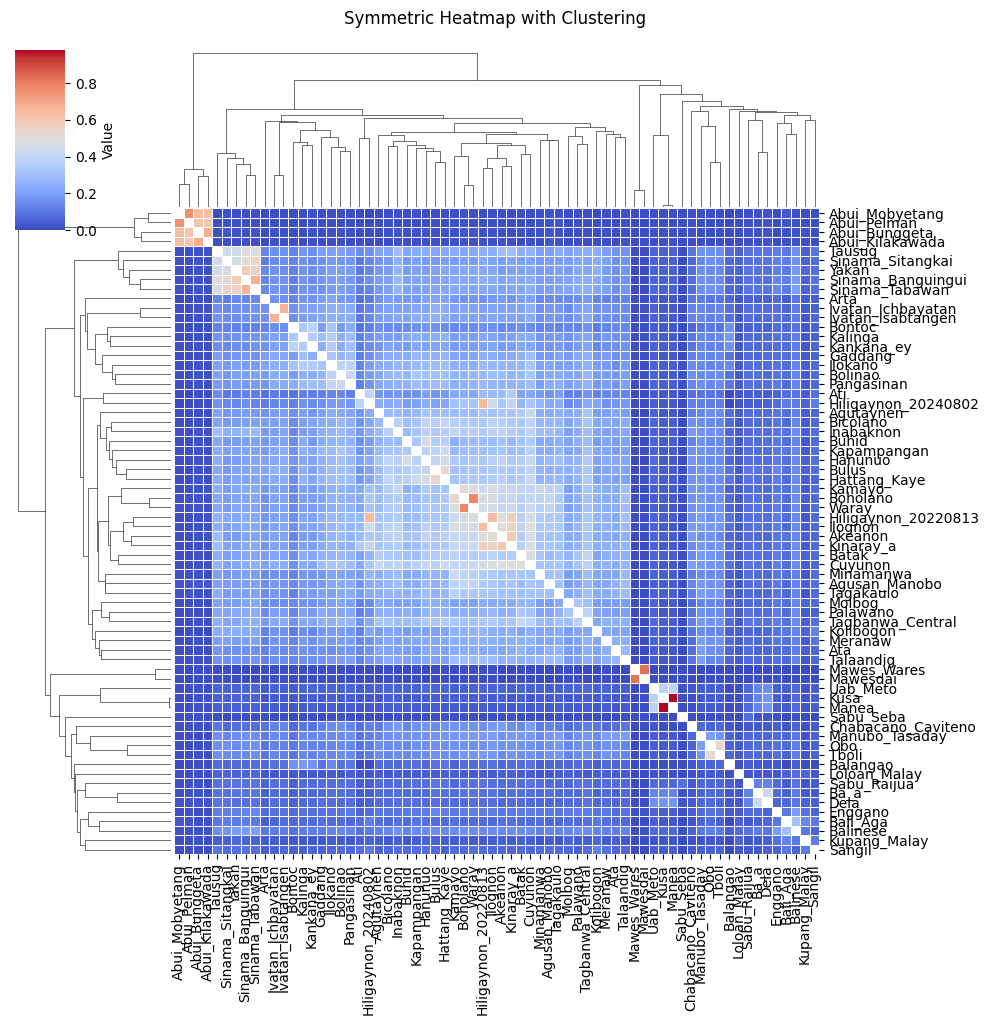

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

mask = np.eye(len(adj_df), dtype=bool)

# Create a clustered heatmap
sns.clustermap(
    scaled_df,
    cmap="coolwarm",          # or any other colormap you like
    linewidths=0.5,
    mask=mask, 
    figsize=(10, 10),
    xticklabels=True,
    yticklabels=True,
    row_cluster=True,
    col_cluster=True,
    cbar_kws={'label': 'Value'},
    dendrogram_ratio=(0.2, 0.2),  # size of dendrograms
    metric="euclidean",           # distance metric for clustering
    method="average"              # linkage method
)

plt.suptitle("Symmetric Heatmap with Clustering", y=1.02)
plt.show()

In [35]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [36]:
# Remove the index/column labels for PCA
X = adj_scaled_df.values

# Standardize the data
X_scaled = StandardScaler().fit_transform(X)

In [37]:
ncomp=15
pca = PCA(n_components=ncomp)
components = pca.fit_transform(X_scaled)
# Explained variance ratios
explained_variance = pca.explained_variance_ratio_

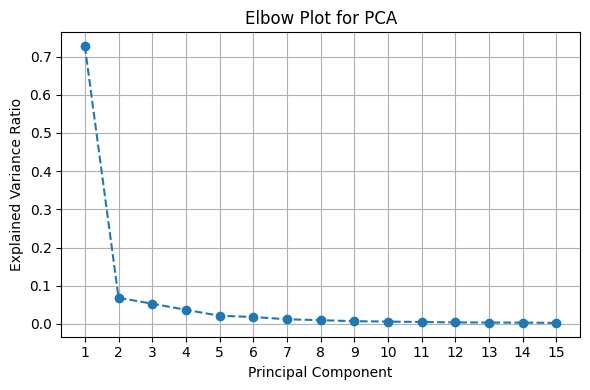

In [38]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, ncomp+1), explained_variance, marker='o', linestyle='--')
plt.xticks(range(1, ncomp+1))
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Elbow Plot for PCA')
plt.grid(True)
plt.tight_layout()
plt.show()

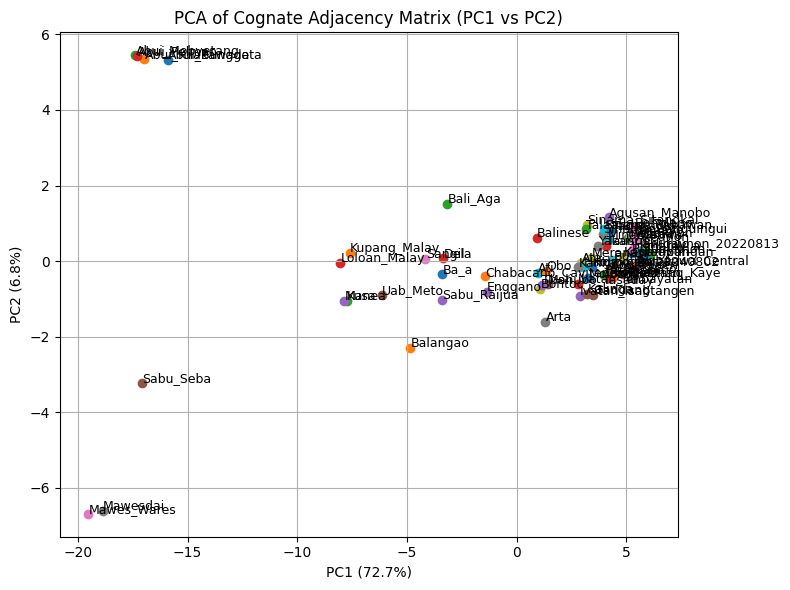

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Plot only the first two PCs
for i, lang in enumerate(adj_df.index):
    x, y = components[i, 0], components[i, 2]
    plt.scatter(x, y, label=lang)
    plt.text(x + 0.02, y + 0.02, lang, fontsize=9)

plt.title("PCA of Cognate Adjacency Matrix (PC1 vs PC2)")
plt.xlabel("PC1 ({:.1f}%)".format(pca.explained_variance_ratio_[0] * 100))
plt.ylabel("PC2 ({:.1f}%)".format(pca.explained_variance_ratio_[1] * 100))
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
collectionsheet=pd.read_excel("OCSEAN_initial_englishsheet.xlsx")
collectionsheet.head()

,Unnamed: 0,Language_BasedOnMasterSheet,ISO code (from Original_FileName),COUNTRY,LocalWordsPresent,QC_done,AddedToTheUnitedLanguagesMasterFile,Comment,Separator,Mismatches_Eng,Mismatches_IndoOrTaga,Original_FileName,QC_FileName,Google Map Coordinate,latitude,longitude,Used,Has_IPA,Has_English,Language_AsInFile
0,0,Abui Bunggeta,ABZ,Indonesia,604,Yes,Yes,Some English and or Indonesian words in this l...,", and ; and ~ (?). Only used , and ;",41,87,OCSEAN-ABZ_20240605-BUNGGETA_WORDLIST.xlsx,OCSEAN-ABZ_20240605-BUNGGETA_WORDLIST_PostQC.xlsx,NaN,NaN,NaN,True,True,True,Abui_Bunggeta
1,1,Abui Kilakawada,ABZ,Indonesia,604,Yes,Yes,English and English Elicitation notes complete...,", and ; and ~ (?). Only used , and ;",41,87,OCSEAN-ABZ_20240606-KILAKAWADA_WORDLIST.xlsx,OCSEAN-ABZ_20240606-KILAKAWADA_WORDLIST_PostQC...,NaN,NaN,NaN,True,False,True,Abui_Kilakawada
2,2,Abui Mobyetang,ABZ,Indonesia,602,Yes,Yes,English Elicitation = English actually. Some E...,", and ; and ~ (?). Only used , and ;",41,87,OCSEAN-ABZ_20240610-MOBYETANG_WORDLIST.xlsx,OCSEAN-ABZ_20240610-MOBYETANG_WORDLIST_PostQC....,NaN,NaN,NaN,True,False,True,Abui_Mobyetang
3,3,Abui Pelman,ABZ,Indonesia,602,Yes,Yes,English Elicitation = English actually. Some E...,", and ; and ~ (?). Only used , and ;",41,87,OCSEAN-ABZ_20240610-PELMAN_WORDLIST.xlsx,OCSEAN-ABZ_20240610-PELMAN_WORDLIST_PostQC.xlsx,NaN,NaN,NaN,True,False,True,Abui_Pelman
4,10,Agusan Manobo,MSM,the Phillipines,1225,Yes,Yes,Tagalog and English present and both match the...,",",FALSE,FALSE,OCSEAN-MSM_20240517-WORDLIST_1to1228.xlsx,OCSEAN-MSM_20240517-WORDLIST_1to1228_PostQC.xlsx,"9°15'55.8""N 125°33'33.5""E",9.2655,125.559306,True,False,True,Agusan_Manobo


In [41]:
from shapely.geometry import Point # Allows ployying points with geopandas and rxr
import geopandas as gpd

languages=collectionsheet[collectionsheet["latitude"].notnull()].copy()
# Convert to GeoDataFrame
languages["geometry"] = languages.apply(lambda row: Point(row["longitude"], row["latitude"]), axis=1)
languages_gdf = gpd.GeoDataFrame(languages, geometry="geometry", crs="EPSG:4326")
languages_gdf["Latitude"]=languages_gdf["latitude"]
languages_gdf["Longitude"]=languages_gdf["longitude"]
languages_gdf["Language"]=languages_gdf["Language_BasedOnMasterSheet"]
#languages_gdf = languages_gdf.to_crs(rds.rio.crs)
languages_gdf.head()

,Unnamed: 0,Language_BasedOnMasterSheet,ISO code (from Original_FileName),COUNTRY,LocalWordsPresent,QC_done,AddedToTheUnitedLanguagesMasterFile,Comment,Separator,Mismatches_Eng,...,latitude,longitude,Used,Has_IPA,Has_English,Language_AsInFile,geometry,Latitude,Longitude,Language
4,10,Agusan Manobo,MSM,the Phillipines,1225,Yes,Yes,Tagalog and English present and both match the...,",",FALSE,...,9.265500,125.559306,True,False,True,Agusan_Manobo,POINT (125.55931 9.2655),9.265500,125.559306,Agusan Manobo
6,12,Akeanon,AKL,the Phillipines,1123,Yes,"Yes, but there are problems with a lot of words",A lot of mismatching data in both reference la...,", and /",150,...,11.677084,122.322380,True,False,True,Akeanon,POINT (122.32238 11.67708),11.677084,122.322380,Akeanon
9,18,Ati,ATK,the Phillipines,526,Yes,"Yes, but there are problems with a lot of words",It had two columns of interest: `Ati initial l...,",",150,...,110.175500,122.982800,True,False,True,Ati,POINT (122.9828 110.1755),110.175500,122.982800,Ati
10,19,Ba'a,LLG,Indonesia,1175,Yes,Yes,"Very messy data columns, a lot of irrelevant a...",",",57,...,-10.728535,123.061583,True,True,True,Ba_a,POINT (123.06158 -10.72854),-10.728535,123.061583,Ba'a
12,22,Bali Aga,BAN,Indonesia,197,Yes,Yes,NaN,Space in some words? Don't understand the lang...,FALSE,...,-8.237046,115.028282,True,False,True,Bali_Aga,POINT (115.02828 -8.23705),-8.237046,115.028282,Bali Aga


In [42]:
def date_line_remove (geo,long="Longitude"):
    geo["Longitude2"]=[(x-360 if x>0 else x) for x in geo[long]]
    return geo

languages_gdf=date_line_remove(languages_gdf)
languages_gdf.head()

,Unnamed: 0,Language_BasedOnMasterSheet,ISO code (from Original_FileName),COUNTRY,LocalWordsPresent,QC_done,AddedToTheUnitedLanguagesMasterFile,Comment,Separator,Mismatches_Eng,...,longitude,Used,Has_IPA,Has_English,Language_AsInFile,geometry,Latitude,Longitude,Language,Longitude2
4,10,Agusan Manobo,MSM,the Phillipines,1225,Yes,Yes,Tagalog and English present and both match the...,",",FALSE,...,125.559306,True,False,True,Agusan_Manobo,POINT (125.55931 9.2655),9.265500,125.559306,Agusan Manobo,-234.440694
6,12,Akeanon,AKL,the Phillipines,1123,Yes,"Yes, but there are problems with a lot of words",A lot of mismatching data in both reference la...,", and /",150,...,122.322380,True,False,True,Akeanon,POINT (122.32238 11.67708),11.677084,122.322380,Akeanon,-237.677620
9,18,Ati,ATK,the Phillipines,526,Yes,"Yes, but there are problems with a lot of words",It had two columns of interest: `Ati initial l...,",",150,...,122.982800,True,False,True,Ati,POINT (122.9828 110.1755),110.175500,122.982800,Ati,-237.017200
10,19,Ba'a,LLG,Indonesia,1175,Yes,Yes,"Very messy data columns, a lot of irrelevant a...",",",57,...,123.061583,True,True,True,Ba_a,POINT (123.06158 -10.72854),-10.728535,123.061583,Ba'a,-236.938417
12,22,Bali Aga,BAN,Indonesia,197,Yes,Yes,NaN,Space in some words? Don't understand the lang...,FALSE,...,115.028282,True,False,True,Bali_Aga,POINT (115.02828 -8.23705),-8.237046,115.028282,Bali Aga,-244.971718


In [43]:
?ax.set_extent

Object `ax.set_extent` not found.


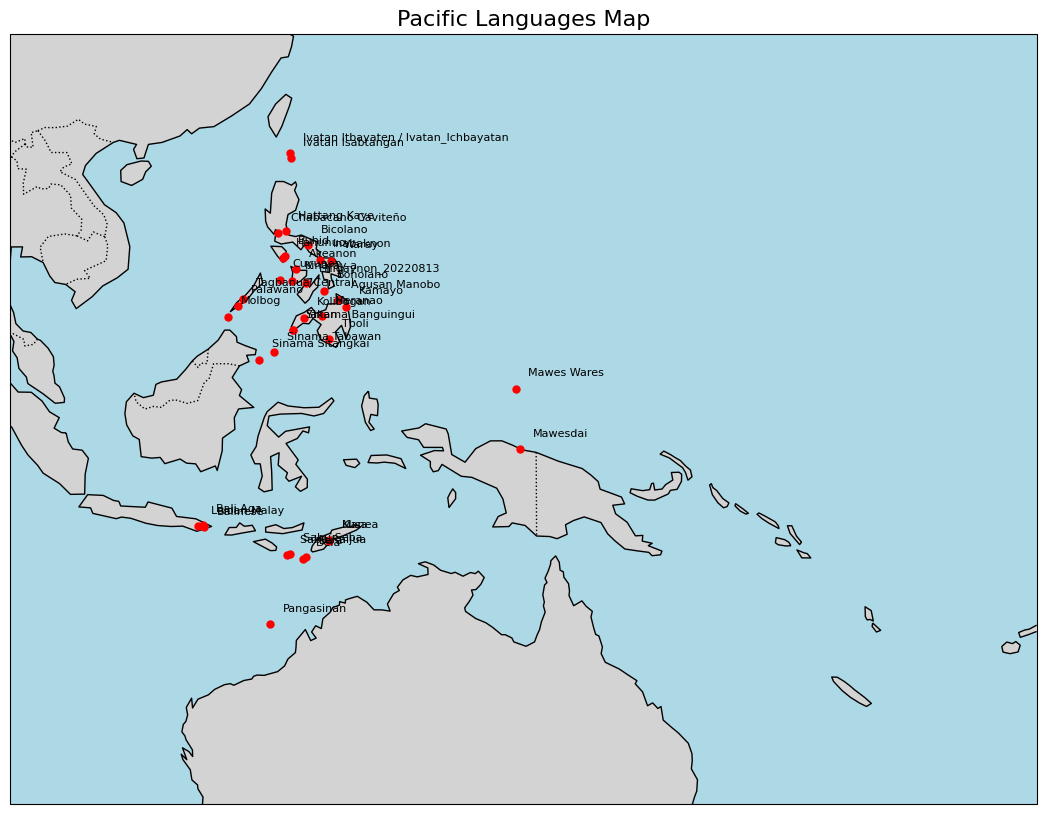

In [44]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Assuming polynesia_geo has columns: 'Language', 'Latitude', 'Longitude'

fig = plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

# Set map extent to roughly cover the Pacific region
#ax.set_extent([100, -100, 100, 30], crs=ccrs.PlateCarree())
ax.set_extent([100, 180, -30, 30], crs=ccrs.PlateCarree())

# Add map features for context
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot each language point and label it
for idx, row in languages_gdf.iterrows():
    ax.plot(row['Longitude'], row['Latitude'], 'o', color='red', markersize=5, transform=ccrs.PlateCarree())
    ax.text(row['Longitude'] + 1, row['Latitude'] + 1, row['Language'], fontsize=8, transform=ccrs.PlateCarree())

plt.title("Pacific Languages Map", fontsize=16)
plt.show()